# Reconstruction

Reconstruction of the image with only the most important wavelet coefficients highlighted by the WCAM.

In [1]:
# Libraries and imports
import sys
sys.path.append('../')

import os
import numpy as np
import matplotlib.pyplot as plt
from utils import helpers
import torchvision
import pandas as pd
from PIL import Image
from torchvision.models import resnet50
import torch
from spectral_sobol.torch_explainer import WaveletSobol


2023-04-14 18:10:32.595036: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-14 18:10:33.346991: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [1]:
import json

completed = json.load(open('../completed.json'))
initial_list = json.load(open('../initial_list.json'))

In [32]:
len(initial_list)

5000

In [30]:
f = open("../../data/ImageNet/val.txt", "r")
raw = f.read().split('\n')
items = {r[:28] : int(r[29:]) for r in raw if r[:10] == 'ILSVRC2012'}

import pandas as pd

labels = pd.DataFrame.from_dict(items, orient = 'index').reset_index()
labels = labels[labels['index'].isin(initial_list)]
labels.shape

(4751, 2)

In [41]:
len([i for i in initial_list if i[0] == '.'])

0

In [40]:
import os

exists = [os.path.exists('../../data/ImageNet/{}'.format(k)) for k in completed]
sum(exists), len(exists)

(4751, 4751)

In [39]:
images = labels['index'].values

for n in initial_list:

    if n not in completed:

        print('flksdlfkjsdl')

In [2]:
# folders
imagenet_dir = "../../data/ImageNet/"

# device and model
device = 'cuda:2'
model = resnet50(pretrained = True).to(device)

# parameters
grid_size = 28
batch_size = 128

## Examples

In [3]:
# Set up 
classes = {
 'fox.png': 278,
 'snow_fox.png': 279,
 'polar_bear.png': 296,
 'leopard.png': 288,
 'fox1.jpg': 277,
 'fox2.jpg': 277,
 'sea_turtle.jpg': 33,
 'lynx.jpg': 287,
 'cat.jpg': 281,
 'otter.jpg': 360
}

image_names = list(classes.keys())

images = [Image.open('../assets/{}'.format(img_name)) for img_name in image_names]

# transforms
normalize = torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

preprocessing = torchvision.transforms.Compose([
    torchvision.transforms.Resize(256),
    torchvision.transforms.CenterCrop(224),
    torchvision.transforms.ToTensor(),
    normalize,
])
 
x = torch.stack(
    [preprocessing(img) for img in images]
).to(device)

y = np.array([classes[img_name] for img_name in image_names])

# compute the explanations
# downs
wavelet = WaveletSobol(model, grid_size = grid_size, nb_design = 8, batch_size = batch_size, opt = {'size' : grid_size})
explanations = wavelet(x,y)

RuntimeError: CUDA out of memory. Tried to allocate 196.00 MiB (GPU 2; 11.90 GiB total capacity; 5.72 GiB already allocated; 89.62 MiB free; 5.81 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
# compute the sets of perturbed images
altered_images = {
    name : helpers.reconstruct_images(image.cpu().permute(1,2,0), cam) for name, image, cam in zip(classes.keys(), x, explanations)
}

# inference on the altered images
altered_inference = {}

for image_name in altered_images.keys():

    images = altered_images[image_name]

    x = torch.stack(
        [preprocessing(img) for img in images]  
    ).to(device)

    altered_inference[image_name] = {
        'preds' : helpers.evaluate_model_on_samples(x, model, batch_size),
        'label' : classes[image_name]
    }

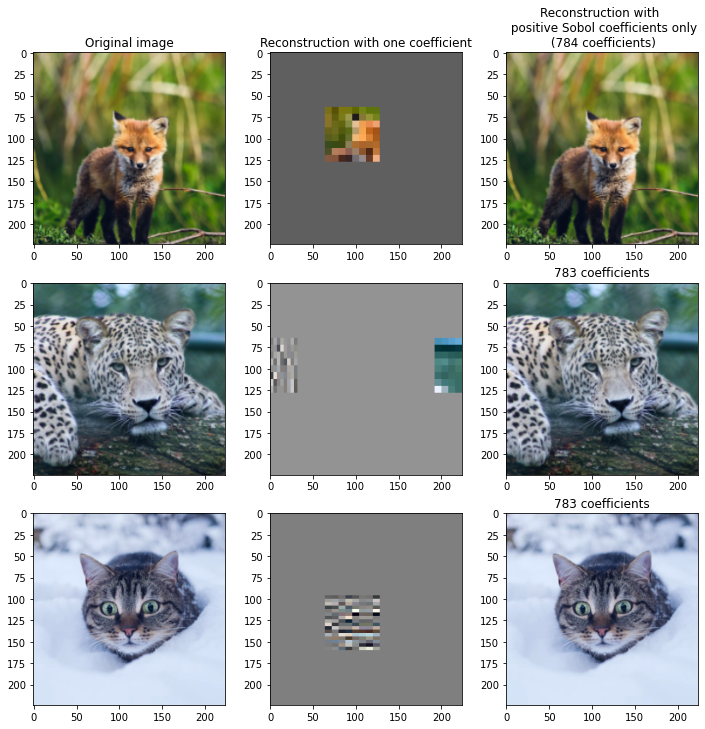

In [22]:
# some plots of the altered and reconstructed images

fig, ax = plt.subplots(3,3, figsize = (12,12))

names = ['fox.png', 'leopard.png', 'cat.jpg']

for i,image_name in enumerate(names):

    # original image (all coefficients)
    ax[i,0].imshow(altered_images[image_name][-1])
    ax[i,1].imshow(altered_images[image_name][0])
    ax[i,2].imshow(altered_images[image_name][-2])

    n_pos = len(altered_images[image_name]) - 2

    if i > 0:
        ax[i,2].set_title('{} coefficients'.format(n_pos))

ax[0,0].set_title('Original image')
ax[0,1].set_title('Reconstruction with one coefficient')

n_pos = len(altered_images[names[0]]) - 1
ax[0,2].set_title('Reconstruction with \n positive Sobol coefficients only\n ({} coefficients)'.format(n_pos))


plt.show()



In [38]:
# some plots of the model' predictions

## Reconstruction depth and robustness

We define the reconstruction depth as the number of coefficients necessary to reconstruct an image that is accurately predicted by the model. We wonder whether this metric correlates with the robustness of a prediction. We measure the robustness of the prediction as the ratio between images that are accurately predicted over the total number of perturbation. It encompasses two dimensions: the strenth of the corruption and the type of corruption. 

In [ ]:
# sample images from imagenet
np.random.seed(42)

n_samples = 1

source_img_names = np.random.choice(os.listdir(imagenet_dir), n_samples)

source_images = [Image.open(os.path.join(imagenet_dir, img_name)).convert('RGB') for img_name in source_img_names]

# compute the set of perturbed images
perturbed_images = {
    img_name : helpers.compute_corrupted_images(image) for img_name, image in zip(source_images, source_images)
}

# create a dataframe with the labels of each image included in the wcam directory
labels_raw = open(os.path.join(imagenet_dir, 'val.txt')).read().split('\n')
labels_dict = {r[:28] : int(r[29:]) for r in labels_raw if r[:10] == 'ILSVRC2012'}
labels_true = pd.DataFrame.from_dict(labels_dict, orient = "index").reset_index()
labels_true.columns = ['name', 'label']
labels_true = labels_true[labels_true['name'].isin(source_img_names)] # restrict to the images studied

# initialize the Wavelet CAM
WaveletSobol(model, grid_size = grid_size, nb_design = 8, batch_size = batch_size, opt = {'size' : grid_size})

# compute the robustness and the reconstruction depth

robustness = []
reconstruction_depth = {
    'source'  : [],
    'corrupted' : []
}

for i, name in enumerate(list(perturbed_images.keys())):

    # retrive the images
    images = perturbed_images[name]

    # transforms and convert as a tensor
    x = torch.stack(
        [[preprocessing(img) for img in images]]
    ).to(device)

    # label
    label = labels_true[labels_true['name'] == name]['label'].value

    # evaluate the model and compute the robustness 
    # append it to the list
    preds = helpers.evaluate_model_on_samples(x, model, batch_size)
    robustness.append(len((preds ==  label * np.ones(len(preds)) / preds)))

    # compute the reconstruction depth on the source image and a random perturbed image
    source_image = source_images[i]
    index = np.random.randint(1,6, size = len(images))
    perturbed_image = images[index]

    # compute the wcam
    imgs = torch.stack(
        [preprocessing(im) for im in [source_image, perturbed_image]]
    ).to(device)

    # label
    y = label * np.ones(2)

    # compute the explanations
    explanations = wavelet(imgs, y)

    # altered images: images that are reconstructed from the sobol index
    altered_images = {
        'source' : helpers.reconstruct_images(source_image, explanations[0]),
        'corrupted' : helpers.reconstruct_images(perturbed_image, explanations[1])
    }

    # inference on the reconstructed images
    altered_inference = {}

    for case in altered_images.keys():

        images = altered_images[case]

        x = torch.stack(
            [preprocessing(img) for img in images]  
        ).to(device)

        altered_inference[case] = helpers.evaluate_model_on_samples(x, model, batch_size)

        # find the index of the first correct prediction
        try:
            depth = np.min(np.where(preds == label * np.ones(len(preds)))[0])
        except ValueError:
            depth = np.nan
            
        reconstruction_depth[case].append(depth)

In [ ]:
# plots : reconstruction depth v. robustness
plt.scatter(robustness, reconstruction_depth['source'])
plt.show()